# HW1_NLP

Задание с платформы SF:
Мы разбили ваш проект на 2 части и предлагаем начать выполнение 1 части. Ниже вы найдете все детали этого задания. Советуем выполнить его прямо сейчас, сохранить ваш jupiter-ноутбук и отправить все три выполненных части проекта на проверку на последней неделе курса.

## ЗАДАЧА
* Сделайте EDA.
* Придумайте эвристику для предсказания целевого класса. На данном этапе нельзя использовать ML, допускаются исключительно наивные методы.
* Реализуйте один из методов векторизации текста и обучите одну из моделей классического ML для данной задачи. Можно использовать любые библиотеки.
* Предложите метрику, разбейте обучающую выборку на обучающую и валидационную и посчитайте её значение для методов, реализованных в пункте 2 и 3.

# Подключение необходимых библиотек

In [1]:
#pip install nltk

In [2]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import NLTKWordTokenizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils import compute_class_weight

import os
import pickle


import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
from loguru import logger
import re
import string
from pprint import pprint


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


#nltk.download('stopwords')
from nltk.corpus import stopwords
#nltk.download('omw-1.4')
#DATA_FOLDER = os.path.abspath("./data/")
TRAIN_PATH = os.path.join("train.csv")
BASELINE_PATH = os.path.join("baseline.json")
PALETTE = sns.color_palette("Spectral", 5)
STOPWORDS = nltk.corpus.stopwords.words('english')


# EDA

## 1. датасет

In [3]:
train_df = pd.read_csv(TRAIN_PATH, usecols=["Text", "Sentiment"])
train_df.columns = ["text", "sentiment"]
train_df

,text,sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...
41154,Airline pilots offering to stock supermarket s...,Neutral
41155,Response to complaint not provided citing COVI...,Extremely Negative
41156,You know itÂs getting tough when @KameronWild...,Positive
41157,Is it wrong that the smell of hand sanitizer i...,Neutral


## 2. Общая информация

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41159 entries, 0 to 41158
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       41158 non-null  object
 1   sentiment  41155 non-null  object
dtypes: object(2)
memory usage: 643.2+ KB


Содержание
- 2 столбца: столбец с текстами + столбец с собственно оценкой этих текстов
- датасет состоит из 41+ тыс. строк

In [5]:
train_df = train_df.dropna().reset_index(drop=True)
train_df = train_df.drop_duplicates().reset_index(drop=True)
train_df

,text,sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...
41150,Airline pilots offering to stock supermarket s...,Neutral
41151,Response to complaint not provided citing COVI...,Extremely Negative
41152,You know itÂs getting tough when @KameronWild...,Positive
41153,Is it wrong that the smell of hand sanitizer i...,Neutral


### 2.2. sentiment

In [6]:
print(
    "Частоты оценок, шт:",
    train_df["sentiment"].value_counts(),
    sep="\n",
    end="\n\n",
)

print(
    "Частоты оценок, %:",
    train_df["sentiment"].value_counts(True).apply(lambda x: (round(x, 3))) * 100,
    sep="\n",
)

Частоты оценок, шт:
Positive              11422
Negative               9917
Neutral                7711
Extremely Positive     6624
Extremely Negative     5481
Name: sentiment, dtype: int64

Частоты оценок, %:
Positive              27.8
Negative              24.1
Neutral               18.7
Extremely Positive    16.1
Extremely Negative    13.3
Name: sentiment, dtype: float64


In [7]:
train_df["sentiment"].value_counts().index.to_list()

['Positive', 'Negative', 'Neutral', 'Extremely Positive', 'Extremely Negative']

Прослеживается:
- преобладание количества позитивных оценок (более 11 тыс.) над негативными почти (10 тыс. значений)
- нейтральных оценок меньше


In [8]:
# Переведем оценки -> в порядковую шкалу (от 1 до 5):
sentiment_dict = {
    "Extremely Positive": 5,
    "Positive": 4,
    "Neutral": 3,
    "Negative": 2,
    "Extremely Negative": 1
}
train_df["sentiment"] = train_df["sentiment"].apply(lambda x: sentiment_dict[x])
train_df

,text,sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,3
1,advice Talk to your neighbours family to excha...,4
2,Coronavirus Australia: Woolworths to give elde...,4
3,My food stock is not the only one which is emp...,4
4,"Me, ready to go at supermarket during the #COV...",1
...,...,...
41150,Airline pilots offering to stock supermarket s...,3
41151,Response to complaint not provided citing COVI...,1
41152,You know itÂs getting tough when @KameronWild...,4
41153,Is it wrong that the smell of hand sanitizer i...,3


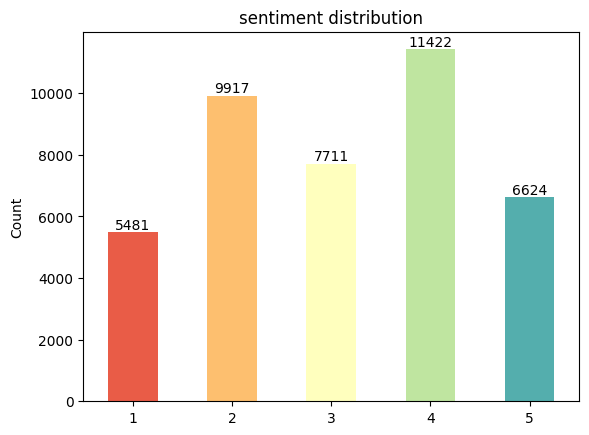

In [9]:
# Частота оценок:
ax = train_df["sentiment"].value_counts().sort_index().plot.bar(
    color=PALETTE,
    title="sentiment distribution",
    rot=0,
)

for bars in ax.containers:
    ax.bar_label(bars)

ax.set_ylabel("Count");

### 2.3. Работа с текстом

#### 2.3.1. Добавление новых признаков

In [10]:

def add_text_features(df: pd.DataFrame, column: str = "text") -> pd.DataFrame:
    """Returns new DataFrame with text features from column"""
    df["text_split"] = df[column].apply(lambda x: str(x).lower().strip().split())
    df["text_symbols_n"] = df[column].apply(lambda x: len(str(x)))
    df["text_list_len"] = df["text_split"].apply(lambda x: len(x))
    df["text_set_len"] = df["text_split"].apply(lambda x: len(set(x)))
    return df

In [11]:
train_df = add_text_features(train_df)
train_df

,text,sentiment,text_split,text_symbols_n,text_list_len,text_set_len
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,3,"[@menyrbie, @phil_gahan, @chrisitv, https://t....",111,8,7
1,advice Talk to your neighbours family to excha...,4,"[advice, talk, to, your, neighbours, family, t...",237,38,33
2,Coronavirus Australia: Woolworths to give elde...,4,"[coronavirus, australia:, woolworths, to, give...",131,14,14
3,My food stock is not the only one which is emp...,4,"[my, food, stock, is, not, the, only, one, whi...",306,42,37
4,"Me, ready to go at supermarket during the #COV...",1,"[me,, ready, to, go, at, supermarket, during, ...",310,40,36
...,...,...,...,...,...,...
41150,Airline pilots offering to stock supermarket s...,3,"[airline, pilots, offering, to, stock, superma...",102,12,12
41151,Response to complaint not provided citing COVI...,1,"[response, to, complaint, not, provided, citin...",138,23,22
41152,You know itÂs getting tough when @KameronWild...,4,"[you, know, itâs, getting, tough, when, @kame...",136,18,18
41153,Is it wrong that the smell of hand sanitizer i...,3,"[is, it, wrong, that, the, smell, of, hand, sa...",111,18,16


In [12]:
train_df.to_csv("preprocessed.csv", index=False)

In [34]:
# статистические показатели:
train_df.describe()

,sentiment,text_symbols_n,text_list_len,text_set_len
count,41155.000000,41155.000000,41155.000000,41155.000000
mean,3.092115,204.197692,30.500255,27.763091
std,1.298687,68.655884,11.591438,9.754834
min,1.000000,11.000000,1.000000,1.000000
25%,2.000000,151.000000,21.000000,20.000000
50%,3.000000,215.000000,32.000000,29.000000
75%,4.000000,259.000000,40.000000,36.000000
max,5.000000,355.000000,64.000000,51.000000


- в среднем длина текста составляет 204 символа
- среднее количество слов равно 30.5
- среднее количество уникальных слов 27.7

#### 2.3.2. Гистограммы для новых признаков

##### Длина текста

255    2297
280     461
279     417
278     375
281     324
       ... 
340       1
334       1
333       1
335       1
12        1
Name: text_symbols_n, Length: 329, dtype: int64

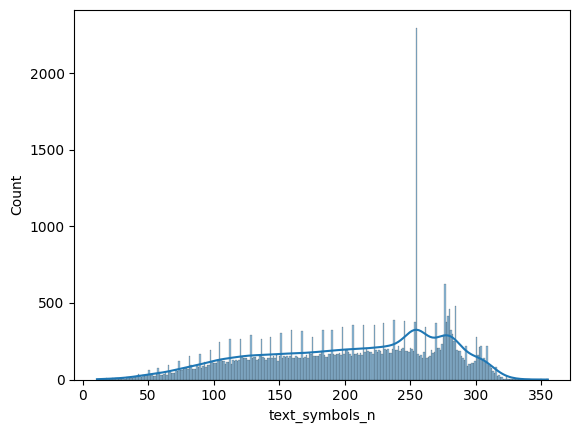

In [35]:
display(train_df["text_symbols_n"].value_counts())
sns.histplot(train_df["text_symbols_n"], bins=300, kde=True);

По длине текста <= 360 символов

In [36]:
train_df[train_df["text_symbols_n"] == 255]["text"].values[:3]

array(['@10DowningStreet @grantshapps what is being done to ensure food and other essential products are being re-stocked at supermarkets and panic buying actively discouraged? It cannot be left to checkout staff to police the actions of the selfish and profiteer',
       '@TheJoshuaTurner @Loreign83 @peanut_astro @my_amigouk @afneil @BorisJohnson @patel4witham This is both disgusting and disgraceful charging over inflated prices for items for stopping the spread of COVID-19, the government really needs to do something abou',
       '@kroger Instead of paid sick leave, @kroger is providing 2 weeks paid leave ONLY to people who test positive for COVID-19 or are placed under mandatory quarantine\r\r\n\r\r\nThis is insufficient to protect staff and the public, especially with little testing av'],
      dtype=object)

##### Число слов

40    1377
41    1349
37    1341
39    1331
38    1321
      ... 
1        2
61       1
60       1
64       1
62       1
Name: text_list_len, Length: 63, dtype: int64

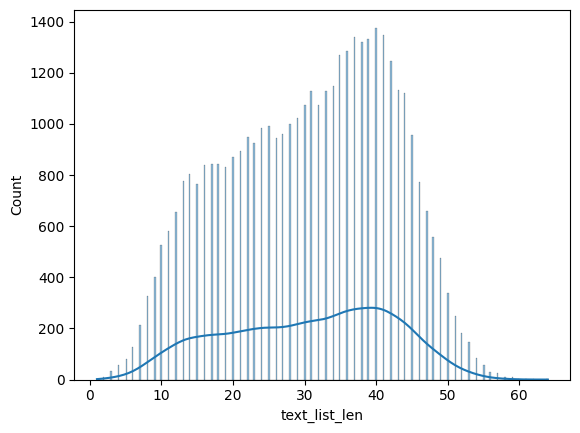

In [37]:
display(train_df["text_list_len"].value_counts())
sns.histplot(train_df["text_list_len"], bins=300, kde=True);

- сильных выбросов нет, все в нормали
- больше всего текстов содержащих 40 слов

##### Число уникальных слов в отзыве

36    1773
35    1756
34    1635
33    1619
37    1598
Name: text_set_len, dtype: int64

1      2
51     4
2     12
50    16
49    25
Name: text_set_len, dtype: int64

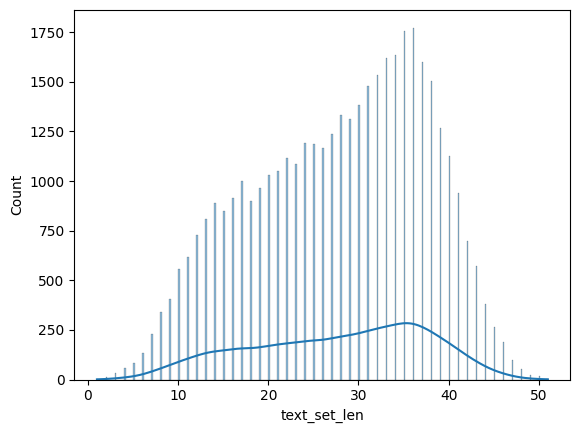

In [38]:
display(train_df["text_set_len"].value_counts().nlargest(5))
display(train_df["text_set_len"].value_counts().nsmallest(5))
sns.histplot(train_df["text_set_len"], bins=300, kde=True);

- сильных выбросов нет
- больше всего текстов по 36 уникальных слов

#### 2.3.3. Сводная таблица по новым признакам

In [39]:
# Создадим сводную таблицу со средними значениями новых признаков в зависимости от оценки:
pivot = pd.pivot_table(
    train_df,
    values=["text_symbols_n", "text_list_len", "text_set_len"],
    index="sentiment"
)
pivot = pivot.apply(lambda x: round(x, 2))
pivot

,text_list_len,text_set_len,text_symbols_n
sentiment,,,
1,34.46,31.03,221.48
2,30.65,27.94,203.33
3,23.14,21.48,168.14
4,30.92,28.16,207.06
5,34.85,31.43,228.24


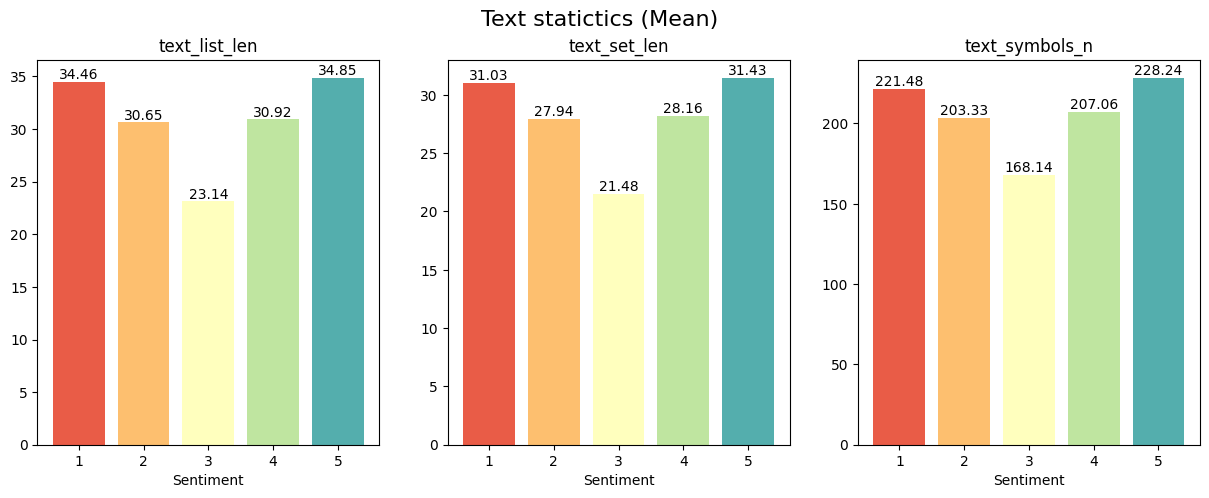

In [40]:
# Визуализируем данную таблицу:
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("Text statictics (Mean)", fontsize=16)

for index, column in enumerate(pivot.columns):
    ax = axs[index]
    ax.bar(
        x=pivot.index,
        height=pivot[column],
        color=PALETTE,
    )
    ax.set_title(column)
    ax.set_xlabel("Sentiment")

    for bars in ax.containers:
        ax.bar_label(bars)

Наблюдения:
* Нейтральные оценки самые короткие
* Чем больше оценка, тем больше в среднем тексты по длине (как позитивные, так и негативные)
* Экстремальные оценки (1 и 5) и нормальные оценки (2 и 4) в среднем очень близки по длинам

#### 2.3.4. Анализ популярности слов

In [41]:
# Частота по каждому слову:
all_words_list = []
for text_list in train_df["text_split"]:
    all_words_list.extend(text_list)

all_words_series = pd.Series(all_words_list)
text_count_df = pd.DataFrame(all_words_series.value_counts())
text_count_df["word"] = text_count_df.index
text_count_df.index = range(text_count_df.shape[0])
text_count_df = text_count_df[text_count_df.columns.to_list()[::-1]]
text_count_df["len"] = text_count_df["word"].apply(lambda x: len(x))
text_count_df

,word,0,len
0,the,44544,3
1,to,38189,2
2,and,23850,3
3,of,21459,2
4,a,19205,1
...,...,...,...
120796,#inside,1,7
120797,https://t.co/4ayu5ulny9,1,23
120798,https://t.co/7vxyntxoyj,1,23
120799,https://t.co/6kzkuveeih,1,23


In [42]:
# Оставим слова с длиной больше 4 
text_count_df[text_count_df["len"] > 4].iloc[:30]

,word,0,len
6,#coronavirus,14935,12
15,prices,6654,6
21,grocery,5996,7
23,supermarket,5717,11
25,store,5533,5
26,covid-19,5518,8
28,people,5055,6
30,#covid19,4635,8
36,consumer,4115,8
43,&amp;,3581,5


Основные темы:
- ковид и все что связано с пандемией коронавируса


### 2.4. Выводы:

* Представленные тексты, это тексты написанные во время эпиденмии коронавируса
* Чем более эмоциональный текст, тем более он длинный

## 3. Чистка данных:

In [43]:

train_clean_df = train_df[["text", "sentiment"]].copy()
train_clean_df

,text,sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,3
1,advice Talk to your neighbours family to excha...,4
2,Coronavirus Australia: Woolworths to give elde...,4
3,My food stock is not the only one which is emp...,4
4,"Me, ready to go at supermarket during the #COV...",1
...,...,...
41150,Airline pilots offering to stock supermarket s...,3
41151,Response to complaint not provided citing COVI...,1
41152,You know itÂs getting tough when @KameronWild...,4
41153,Is it wrong that the smell of hand sanitizer i...,3


In [50]:
# Функции для очистки текстов:

# перевести в нижний регистр + обрезать пробельные символы слева и справа
def prepare_text(text: str) -> str:
    "Returns stripped text in low case"
    return text.lower().strip()


# удалить ссылки
def remove_links(text: str) -> str:
    """Removes links and non-ASCII characters"""
    text = "".join([x for x in text if x in string.printable])
    # Removing URLs
    text = re.sub(r"http\S+", "", text)
    return text


# удалить remove_emoji
def remove_emoji(text: str) -> str:
    """Removes emojis"""
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE
    )
    return emoji_pattern.sub(r"", text)


# удалить знаки пунктуации
def remove_punctuations(text: str):
    """Removes punctuations"""
    table = str.maketrans("","",string.punctuation)
    result = text.translate(table)
    return result


# remove_special_chara
def remove_special_characters(text: str) -> str:
    """Removes special characters and digits"""
    pattern = r"[^a-zA-z0-9\s]"
    text = re.sub(pattern,"",text)
    text = re.sub(r"[0-9]+", "", text)
    return text


# remove stopwords
def remove_stopwords(text: str) -> str:
    """Removes stopwords from text"""
    tokenizer = NLTKWordTokenizer()
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token not in STOPWORDS]
    filtered_text = " ".join(filtered_tokens)    
    return filtered_text



# Denoise text
def _strip_html(text: str) -> str:
    """strips text as html"""
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()


def _remove_between_square_brackets(text: str) -> str:
    """removes symbols between square brakets"""
    return re.sub("\[[^]]*\]", "", text)


# Шумопонижение
def denoise_text(text: str) -> str:
    """Strips text as html and removes symbols between square brakets"""
    text = _strip_html(text)
    text = _remove_between_square_brackets(text) 
    return text


# Clean text pipeline
def clean_text_pipeline(text: str) -> str:
    """Cleans input text and returns cleaned one"""
    text = prepare_text(text)
    text = remove_links(text)
    text = remove_emoji(text)
    text = remove_stopwords(text)
    text = remove_punctuations(text)
   # text = convert_abbrev_in_text(text)
    text = denoise_text(text)
    text = remove_special_characters(text)
    return text


# Stem and lemmatize
def stem_text(text):
    """Gets input text and returns stemmed one"""
    stemmer = SnowballStemmer(language="english")
    return " ".join([stemmer.stem(word) for word in text.split()])


# Лемматизация текста
def lemmatize_text(text):
    """Gets input text and returns lemmatized one"""
    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

In [51]:
TEXT_CLEAN_COLUMN = "text_clean"
train_clean_df[TEXT_CLEAN_COLUMN] = train_clean_df["text"].apply(clean_text_pipeline)
train_clean_df['text_stemmer'] = train_clean_df[TEXT_CLEAN_COLUMN].apply(stem_text)
train_clean_df['text_lemma'] = train_clean_df[TEXT_CLEAN_COLUMN].apply(lemmatize_text)
train_clean_df = add_text_features(train_clean_df, TEXT_CLEAN_COLUMN)
train_clean_df

,text,sentiment,text_clean,text_stemmer,text_lemma,text_split,text_symbols_n,text_list_len,text_set_len
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,3,menyrbie philgahan chrisitv,menyrbi philgahan chrisitv,menyrbie philgahan chrisitv,"[menyrbie, philgahan, chrisitv]",30,3,3
1,advice Talk to your neighbours family to excha...,4,advice talk neighbours family exchange phone n...,advic talk neighbour famili exchang phone numb...,advice talk neighbour family exchange phone nu...,"[advice, talk, neighbours, family, exchange, p...",196,27,24
2,Coronavirus Australia: Woolworths to give elde...,4,coronavirus australia woolworths give elderly...,coronavirus australia woolworth give elder dis...,coronavirus australia woolworth give elderly d...,"[coronavirus, australia, woolworths, give, eld...",101,12,12
3,My food stock is not the only one which is emp...,4,food stock one empty please nt panic enough...,food stock one empti pleas nt panic enough foo...,food stock one empty please nt panic enough fo...,"[food, stock, one, empty, please, nt, panic, e...",181,23,20
4,"Me, ready to go at supermarket during the #COV...",1,ready go supermarket covid outbreak m parano...,readi go supermarket covid outbreak m paranoid...,ready go supermarket covid outbreak m paranoid...,"[ready, go, supermarket, covid, outbreak, m, p...",198,23,23
...,...,...,...,...,...,...,...,...,...
41150,Airline pilots offering to stock supermarket s...,3,airline pilots offering stock supermarket shel...,airlin pilot offer stock supermarket shelv nz ...,airline pilot offering stock supermarket shelf...,"[airline, pilots, offering, stock, supermarket...",69,9,9
41151,Response to complaint not provided citing COVI...,1,response complaint provided citing covid relat...,respons complaint provid cite covid relat dela...,response complaint provided citing covid relat...,"[response, complaint, provided, citing, covid,...",109,16,16
41152,You know itÂs getting tough when @KameronWild...,4,know getting tough kameronwilds rationing toi...,know get tough kameronwild ration toilet paper...,know getting tough kameronwilds rationing toil...,"[know, getting, tough, kameronwilds, rationing...",113,13,13
41153,Is it wrong that the smell of hand sanitizer i...,3,wrong smell hand sanitizer starting turn cor...,wrong smell hand sanit start turn coronavirus ...,wrong smell hand sanitizer starting turn coron...,"[wrong, smell, hand, sanitizer, starting, turn...",74,9,8


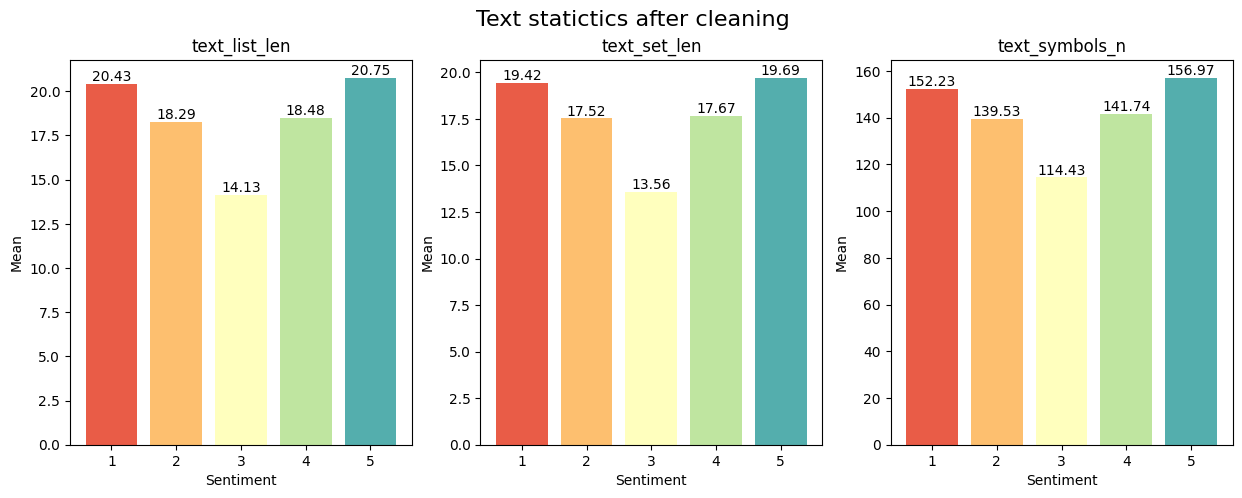

In [52]:

# Статистика после очистки:

TEXT_NUM_COLUMNS = ["text_symbols_n", "text_list_len", "text_set_len"]

pivot_clean = pd.pivot_table(
    train_clean_df,
    values=TEXT_NUM_COLUMNS,
    index="sentiment"
)
pivot_clean = pivot_clean.apply(lambda x: round(x, 2))

fig, axs = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("Text statictics after cleaning", fontsize=16)

for index, column in enumerate(pivot_clean.columns):
    ax: plt.Axes = axs[index]
    ax.bar(
        x=pivot_clean.index,
        height=pivot_clean[column],
        color=PALETTE,
    )
    ax.set_title(column)
    ax.set_xlabel("Sentiment")
    ax.set_ylabel("Mean")

    for bars in ax.containers:
        ax.bar_label(bars)

После очистки все достаточно пропорционально.
При этом соотношения между разными оценками почти не изменились.

,text_symbols_n,text_list_len,text_set_len
mean,139.940202,18.246361,17.421383
std,51.231950,6.724154,6.240491
min,0.000000,0.000000,0.000000
25%,100.000000,13.000000,13.000000
50%,146.000000,19.000000,18.000000
75%,180.000000,23.000000,22.000000
max,280.000000,42.000000,38.000000


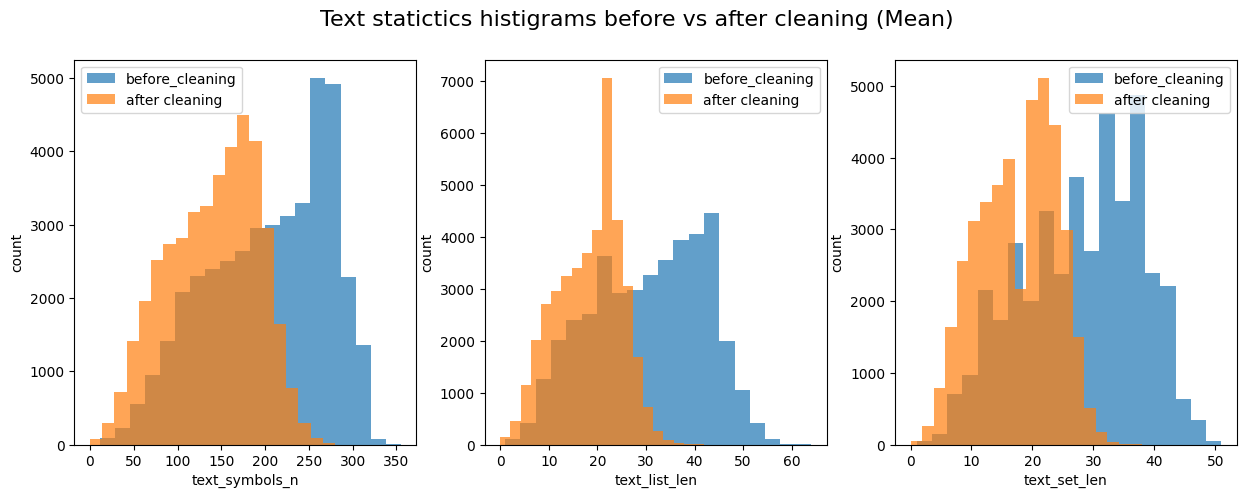

In [53]:
# Гистограммы признакам после:

display(train_clean_df.describe().iloc[1:,1:])

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Text statictics histigrams before vs after cleaning (Mean)", fontsize=16)
for index, column in enumerate(TEXT_NUM_COLUMNS):
    ax: plt.Axes = axs[index]
    for df, status in zip(
        [
            train_df,
            train_clean_df,
        ],
        [
            "before_cleaning",
            "after cleaning",
        ],
    ):
        ax.hist(
            x=df[column],
            label=status,
            bins=20,
            alpha=0.7,
        )
    ax.set_xlabel(column)
    ax.set_ylabel("count")
    ax.legend()

Тексты сильно потеряли в кол-ве символов и слов.

# Процесс моделирования:

## 0. Разделение выборки

In [54]:
# Разделение на тестовую и тренировочную выборку
X = train_clean_df
y = train_clean_df["sentiment"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42
)
X_train_with_y: pd.DataFrame = X_train
X_test_with_y: pd.DataFrame = X_test
X_train: pd.DataFrame = X_train.drop(columns=["sentiment"]) 
X_test: pd.DataFrame = X_test.drop(columns=["sentiment"]) 
y_train = y_train
y_test = y_test

## 1. Baseline

В качестве метрики возьмем accuracy = % правильно указанных классов.

In [55]:
evaluate_df = pd.DataFrame(columns=["method", "accuracy"], index=range(1))
evaluate_df

,method,accuracy
0,NaN,NaN


### 1.1. Random Choise

In [56]:
baseline_df = X_test_with_y.copy()

METHOD = "random"
INDEX = 0
baseline_df[METHOD] = np.random.choice(range(1, 6), size=baseline_df.shape[0])
accuracy = accuracy_score(baseline_df["sentiment"].values, baseline_df[METHOD].values)

evaluate_df.loc[INDEX, "method"] = METHOD
evaluate_df.loc[INDEX, "accuracy"] = accuracy
evaluate_df

,method,accuracy
0,random,0.192929


Для классификации по 5-ти классам получаем 20% точности.

### 1.2. Выделение самого популярного класса:


In [57]:
METHOD = "most_popular"
INDEX = 1
baseline_df[METHOD] = 4
accuracy = accuracy_score(baseline_df["sentiment"].values, baseline_df[METHOD].values)

evaluate_df.loc[INDEX, "method"] = METHOD
evaluate_df.loc[INDEX, "accuracy"] = accuracy
evaluate_df

,method,accuracy
0,random,0.192929
1,most_popular,0.279917


### 1.3. Эвристический анализ по распространенности конкретных слов


In [100]:
# создаем наборы уникальных слов и проверяем тексты в текстовой выборке
stats_dfs_list = []
for sentiment in range(1, 6):
    all_words_list = []
    for text_list in X_train_with_y[X_train_with_y["sentiment"] == sentiment]["text_split"]:
        all_words_list.extend(text_list)
    all_words_series = pd.Series(all_words_list)
    clean_text_count_df = pd.DataFrame(all_words_series.value_counts())
    clean_text_count_df["word"] = clean_text_count_df.index
    clean_text_count_df.index = range(clean_text_count_df.shape[0])
    clean_text_count_df = clean_text_count_df[clean_text_count_df.columns.to_list()[::-1]]
    clean_text_count_df["len"] = clean_text_count_df["word"].apply(lambda x: len(x))
    stats_dfs_list.append(clean_text_count_df)
sets_list = []
for index in range(5):
    sets_list.append(set(stats_dfs_list[index]["word"].values))
union = set.intersection(*sets_list)
unique_words_lists = [sorted(words - union) for words in sets_list]

df_slice = X_test_with_y[["text_split", "sentiment"]].values
logger.info(f"df rows number: {df_slice.shape[0]}")
clf_dict = {}
initial_sentiment_list = [0 for _ in range(5)]
sentiments_list = sorted(X_test_with_y["sentiment"].unique())
logger.debug("Main loop start")
for index, (text, sentiment) in enumerate(df_slice):
    clf_dict.update(
        {
            index: {
                "sentiment": sentiment,
                "evaluation": initial_sentiment_list.copy(),
                "sentiment_pred": 4,
            }
        }
    )
    for word in text:
        for i, unique_words in enumerate(unique_words_lists):
            if word in unique_words:
                clf_dict[index]["evaluation"][i] += 1

    evaluation: list = clf_dict[index]["evaluation"]
    max_words: int = max(evaluation)
    max_words_count = evaluation.count(max_words)
    if max_words_count == 1:
        clf_dict[index]["sentiment_pred"] = evaluation.index(max_words) + 1
    if ((index != 0) and ((index) % 2000 == 0)) or (index == df_slice.shape[0] - 1):
        counter = 0
        for dct in clf_dict.values():
            if dct["sentiment"] == dct["sentiment_pred"]:
                counter += 1
        logger.info(f"Text index = {index}, accuracy = {round(counter / len(clf_dict), 3)}")
logger.debug("Main loop end")

accuracy = counter / len(clf_dict)

2024-01-31 22:12:47.670 | INFO     | __main__:<module>:22 - df rows number: 8231
2024-01-31 22:12:47.672 | DEBUG    | __main__:<module>:26 - Main loop start
2024-01-31 22:14:23.776 | INFO     | __main__:<module>:52 - Text index = 2000, accuracy = 0.316
2024-01-31 22:16:04.388 | INFO     | __main__:<module>:52 - Text index = 4000, accuracy = 0.309
2024-01-31 22:17:40.634 | INFO     | __main__:<module>:52 - Text index = 6000, accuracy = 0.304
2024-01-31 22:19:29.092 | INFO     | __main__:<module>:52 - Text index = 8000, accuracy = 0.302
2024-01-31 22:19:41.434 | INFO     | __main__:<module>:52 - Text index = 8230, accuracy = 0.302
2024-01-31 22:19:41.436 | DEBUG    | __main__:<module>:53 - Main loop end


In [58]:
# Результаты (без запуска вычислений на прошлом этапе)
counter = 2483
len_clf_dict = 8231
accuracy = counter / len_clf_dict

In [59]:
METHOD = "unique_words"
INDEX = 2

evaluate_df.loc[INDEX, "method"] = METHOD
evaluate_df.loc[INDEX, "accuracy"] = accuracy
evaluate_df

,method,accuracy
0,random,0.192929
1,most_popular,0.279917
2,unique_words,0.301664


Точность 30%. Выводы:
- времени очень много необходимо (8к результатов почти за 10 минут)
- минимальное улучшшение

**Вывод**:
выделение на основе уникальных слов, работает чуть лучше, чем оценка классности. 

## 2. Векторизация и классические ML-алгоритмы

In [65]:
vectorizer = CountVectorizer()

vec_train = vectorizer.fit_transform(X_train["text_clean"]).toarray()
vec_test = vectorizer.transform(X_test["text_clean"]).toarray()

In [66]:
#Добавим столбцы с числовыми данными по статистикам очищенного текста:
vec_train = np.hstack([vec_train, X_train[X_train.columns[-3:]].values])
vec_test = np.hstack([vec_test, X_test[X_test.columns[-3:]].values])

In [67]:
#сохраним веса:
y_classes = X_train_with_y["sentiment"].unique()
weights = compute_class_weight(
    class_weight='balanced',
    classes=y_classes,
    y=y_train
)
class_weights = {_class: weight for _class, weight in zip(y_classes, weights)}
class_weights

{3: 1.0653292347516583,
 2: 0.8291110551498363,
 4: 0.7221759157710024,
 5: 1.247121212121212,
 1: 1.495525777878719}

### Наивный Байесовский классификатор:

In [68]:
# константы
METHOD = "multinomial_naive_bayes"
INDEX = 3
MODEL_PATH = f"{METHOD}.pcl"

In [70]:
# модели еще нет => обучаем
model = MultinomialNB()
model.fit(vec_train, y_train)
y_pred = model.predict(vec_test)
accuracy = accuracy_score(y_pred, y_test)
with open(MODEL_PATH, "wb") as file:
    pickle.dump(model, file)

In [71]:
# модель уже есть => для экономии времени подгружаем ее
with open(MODEL_PATH, "rb") as file:
    model: MultinomialNB() = pickle.load(file)
    y_pred = model.predict(vec_test)
    accuracy = accuracy_score(y_pred, y_test)

In [72]:
# результат -> в талблицу
evaluate_df.loc[INDEX, "method"] = METHOD
evaluate_df.loc[INDEX, "accuracy"] = accuracy
evaluate_df

,method,accuracy
0,random,0.192929
1,most_popular,0.279917
2,unique_words,0.301664
3,multinomial_naive_bayes,0.444296


Результат с помощью Байесовского классификатора равен 44%, уже прогресс

Случайный лес:

In [73]:
METHOD = "random_forest_classifier"
INDEX = 4
MODEL_PATH = f"{METHOD}.pcl"

In [74]:
# моделируем
model = RandomForestClassifier(
    n_estimators=100,
    class_weight=class_weights,
    warm_start=True,
    n_jobs=-1,
)
model.fit(vec_train, y_train)
y_pred = model.predict(vec_test)
accuracy = accuracy_score(y_pred, y_test)
with open(MODEL_PATH, "wb") as file:
    pickle.dump(model, file)

In [75]:
# оптимизация (если модель есть)
with open(MODEL_PATH, "rb") as file:
    model: RandomForestClassifier() = pickle.load(file)
    y_pred = model.predict(vec_test)
    accuracy = accuracy_score(y_pred, y_test)

In [76]:
evaluate_df.loc[INDEX, "method"] = METHOD
evaluate_df.loc[INDEX, "accuracy"] = accuracy
evaluate_df

,method,accuracy
0,random,0.192929
1,most_popular,0.279917
2,unique_words,0.301664
3,multinomial_naive_bayes,0.444296
4,random_forest_classifier,0.527153


Случайный лес улучшил результаты на чуть менн 10%, в сравнении с Байесом. Но время расчета увеличилось.

# Вывод

Текст проанализирован на предмет оценки настроения (от 1 до 5 (негатив, позитив)). 
Выводы:
* мы имеем дело с текстами, которые написаны по времена пандемии коронавируса
* чем более эмоциональный подтекст он содержит, тем длиннее текст
Рассмотрели 5 моделей для предсказания настроения текстов.

In [77]:
evaluate_df.to_csv("evaluate.csv", index=False)
X_train_with_y.to_csv("X_train_with_y.csv", index=False)
X_test_with_y.to_csv("X_test_with_y.csv", index=False)